In [206]:
import os
import sys
import csv

sys.path.append('..')

import argparse as ap
import dan.data as ut

from dan.embedding import EmbeddingTransformer
from dan.disguise import Disguise
from dan.discriminator import Discriminator
from dan.dan import DAN
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import seaborn as sns

sns.set(context='poster', style='whitegrid')

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd

In [3]:
DATA_DIR = '../data/processed/mm-cpc'
TEST_CSV = 'test.csv'
JSON_NAME = 'index-cardinality.json'
EXPERIMENT_DIR = '../models/dz-mm-cpc-embedded/256-0.5-0.2-2L/'
DISCRMINATOR_ARCHITECTURE = [64, 32]
DISGUISE_ARCHITECTURE = [256, 256, 256, 256]
LEARNING_RATE = 1e-5  
LAMBDA = 0.5 
ETA = 0.2 

In [4]:
! ls ../models/dz-mm-cpc-embedded/256-0.5-0.2-2L/

checkpoints  hyperparameters.txt  logs	test_results.csv


In [5]:
X_test, y_test = ut.load_data(
os.path.join(DATA_DIR, TEST_CSV),
target='conversion_target')
print('Test data has shape: ', X_test.shape)
print('Test labels has shape: ', y_test.shape)
num_features = X_test.shape[1]

Test data has shape:  (284492, 143)
Test labels has shape:  (284492, 2)


In [75]:
test_data = pd.read_csv(DATA_DIR+"/"+TEST_CSV)
test_data

,am_1024847_bpf,am_1024847_bpr,am_1024847_pixel,am_1024849_bpf,am_1024849_bpr,am_1024849_pixel,am_1024856_bpf,am_1024856_bpr,am_1024856_pixel,am_1057601_bpf,...,os_id_3,os_id_4,os_id_5,os_version,region_id,site_id,size,week_part_0,week_part_1,conversion_target
0,-1.806652,-0.555130,-1.806652,-0.807498,-0.368688,-0.807498,-0.172283,-0.101304,-0.172283,-0.766844,...,0.0,0.0,0.0,0.0,38.0,122.0,50.0,1.0,0.0,1.0
1,0.553510,-0.376657,0.553510,-0.807498,-0.368688,-0.807498,-0.172283,-0.101304,-0.172283,-0.766844,...,0.0,1.0,0.0,87.0,4.0,49968.0,8.0,1.0,0.0,0.0
2,0.553510,-0.503130,0.553510,1.238393,2.537151,1.238393,-0.172283,-0.101304,-0.172283,1.304047,...,0.0,1.0,0.0,82.0,21.0,50313.0,8.0,1.0,0.0,0.0
3,0.553510,-0.047995,0.553510,-0.807498,-0.368688,-0.807498,-0.172283,-0.101304,-0.172283,-0.766844,...,0.0,1.0,0.0,82.0,0.0,20432.0,24.0,1.0,0.0,0.0
4,0.553510,-0.494956,0.553510,-0.807498,-0.368688,-0.807498,-0.172283,-0.101304,-0.172283,1.304047,...,0.0,0.0,0.0,189.0,32.0,7801.0,24.0,1.0,0.0,0.0
5,-1.806652,-0.555130,-1.806652,-0.807498,-0.368688,-0.807498,-0.172283,-0.101304,-0.172283,-0.766844,...,0.0,0.0,0.0,0.0,14.0,122.0,50.0,1.0,0.0,1.0
6,0.553510,0.726973,0.553510,1.238393,4.139398,1.238393,-0.172283,-0.101304,-0.172283,1.304047,...,0.0,1.0,0.0,85.0,20.0,45733.0,8.0,1.0,0.0,0.0
7,-1.806652,-0.555130,-1.806652,1.238393,4.139398,1.238393,-0.172283,-0.101304,-0.172283,1.304047,...,0.0,0.0,0.0,185.0,13.0,38627.0,8.0,1.0,0.0,0.0
8,0.553510,2.255526,0.553510,1.238393,-0.293879,1.238393,-0.172283,-0.101304,-0.172283,-0.766844,...,0.0,1.0,0.0,85.0,14.0,668.0,8.0,1.0,0.0,0.0
9,0.553510,-0.193554,0.553510,1.238393,-0.301808,1.238393,-0.172283,-0.101304,-0.172283,-0.766844,...,0.0,1.0,0.0,82.0,30.0,14077.0,8.0,1.0,0.0,0.0


In [6]:
# Create embedding map
json_path = os.path.join(DATA_DIR, JSON_NAME)
index_cardinality_map = ut.load_cardinality_map(json_path)

In [7]:
checkpoint_dir = os.path.join(EXPERIMENT_DIR, 'checkpoints/')
log_dir = os.path.join(EXPERIMENT_DIR, 'logs/')

# Define DAN model
tf.reset_default_graph()
embedding_transformer = EmbeddingTransformer(index_cardinality_map)
num_features_embedding = embedding_transformer.calc_num_outputs(num_features)
print('Feature dimensionality in embedded space:', num_features_embedding)


disguise = Disguise(num_features_embedding, DISGUISE_ARCHITECTURE)

discriminator = Discriminator(DISCRMINATOR_ARCHITECTURE)
dan = DAN(
    disguise, discriminator, checkpoint_dir, log_dir, embedding_transformer,
    num_inputs=num_features,
    learning_rate=LEARNING_RATE,
    lambd=LAMBDA,
    eta=ETA,
    early_stopping=4)

Feature dimensionality in embedded space: 340


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name cross entropy is illegal; using cross_entropy instead.
INFO:tensorflow:Summary name predictive entropy is illegal; using predictive_entropy instead.
INFO:tensorflow:Summary name discriminator loss is illegal; using discriminator_loss instead.
INFO:tensorflow:Summary name disguise quality is illegal; using disguise_quality instead.
INFO:tensorflow:Summary name disguise success rate is illegal; using disguise_success_rate instead.
INFO:tensorflow:Summary name disguise loss is illegal; using disguise_loss instead.
INFO:tensorflow:Summary name train accuracy is illegal; using train_accuracy instead.
INFO:tensorflow:Summary name train auroc is illegal; using train_auroc instead.
INFO:tensorflow:Summary name validation accuracy is illegal; using validation_accuracy instead.
INFO:tensorflow:Summary name validation auroc is illegal; using validation_auroc instead.
INFO:tensorflow:Restoring parameters from ../models/dz-mm-cpc-embedded/256-0.5-0.2-2L/checkpoints/-449

In [8]:
y_pred = dan.predict_proba(X_test)

In [9]:
accuracy_score(y_test[:,1], y_pred[:,1] >= 0.5)

0.9168201566300634

In [10]:
roc_auc_score(y_test[:,1], y_pred[:,1])

0.958778871852347

In [11]:
print(y_test)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [12]:
boolean_mask_negatives = (y_test[:, 0] == 1)
X_test_positives = X_test[boolean_mask_negatives]
X_test_positives_sample = X_test_positives[0:400]

In [13]:
X_test.shape

(284492, 143)

In [14]:
X_test_positives_sample.shape

(400, 143)

In [15]:
x_input_placeholder = tf.placeholder(dtype=tf.float32, shape=(None, 143))
x_embedded_tensor = embedding_transformer(x_input_placeholder)
x_embedded = dan.sess.run(x_embedded_tensor, feed_dict={x_input_placeholder: X_test_positives_sample})

In [16]:
x_embedded.shape

(400, 340)

In [18]:
X_test_transformed = dan.transform(X_test_positives_sample)

In [19]:
X_test_transformed

array([[ 0.5557521 , -0.37075078,  0.5543072 , ..., -0.08508186,
         0.07516347,  0.00837759],
       [ 0.5556871 , -0.3767113 ,  0.5548778 , ..., -0.11667689,
         0.07730637,  0.00747296],
       [ 0.55348444, -0.39596376,  0.5563416 , ...,  0.13373537,
         0.02812963, -0.13785724],
       ...,
       [ 0.55622655, -0.37651172,  0.5539423 , ..., -0.16709645,
         0.09546416,  0.00555883],
       [ 0.5547548 , -0.36396706,  0.5545244 , ...,  0.10203855,
         0.04595317, -0.14023025],
       [-1.8035756 , -0.5548132 , -1.8084966 , ..., -0.11933322,
         0.10337377,  0.00354113]], dtype=float32)

In [20]:
X_test_transformed.shape

(400, 340)

In [21]:
x_diff = x_embedded - X_test_transformed
x_diff = np.abs(x_diff)

In [22]:
x_diff.max()
x_diff.min()
x_diff.mean()

0.054522116

(array([1.32825e+05, 1.00700e+03, 4.49000e+02, 1.05200e+03, 4.40000e+01,
        3.40000e+01, 4.10000e+01, 3.40000e+01, 1.02000e+02, 3.10000e+01,
        1.70000e+01, 4.50000e+01, 3.30000e+01, 1.00000e+01, 3.90000e+01,
        2.30000e+01, 7.00000e+00, 2.00000e+01, 4.00000e+00, 3.00000e+01,
        1.20000e+01, 5.40000e+01, 1.20000e+01, 1.60000e+01, 2.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.30000e+01, 0.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 7.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+01, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00

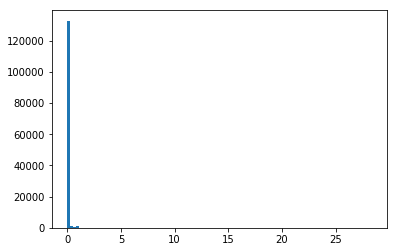

In [23]:
x_diff_1d = x_diff.ravel()
x_diff_1d = pd.Series(x_diff_1d)
plt.hist(x_diff_1d, bins=100)

(array([189.,  34.,  31.,  38., 116.,  22.,  26.,  22.,  39.,  30.,  10.,
         38.,  24.,   6.,  20.,   4.,  30.,   4.,  60.,   6.,  23.,   1.,
          3.,   1.,   0.,   1.,   0.,  12.,   1.,   0.,   1.,   2.,   2.,
          0.,   1.,   0.,   7.,   0.,   0.,   1.,   1.,   1.,   1.,  10.,
          1.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 1.000004 ,  1.2732815,  1.5465587,  1.8198361,  2.0931134,
         2.366391 ,  2.6396682,  2.9129455,  3.1862228,  3.4595003,
         3.7327776,  4.006055 ,  4.279332 ,  4.55261  ,  4.825887 ,
         5.0991645,  5.372442 ,  5.645719 ,  5.9189963,  6.1922736,
         6.4655514,  6.7388287,  7.012106 ,  7

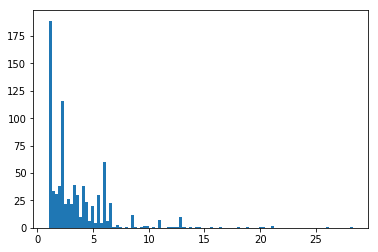

In [24]:
x_diff_big = x_diff_1d[[x > 1 for x in x_diff_1d]]
x_diff_big = pd.Series(x_diff_big)
plt.hist(x_diff_big, bins=100)

(array([8.4714e+04, 1.2876e+04, 7.9750e+03, 5.4450e+03, 4.2030e+03,
        3.1780e+03, 2.2050e+03, 1.7820e+03, 1.4710e+03, 1.2930e+03,
        1.0370e+03, 8.7500e+02, 7.0500e+02, 5.9700e+02, 6.3100e+02,
        4.9600e+02, 5.3100e+02, 3.8800e+02, 3.6900e+02, 3.0200e+02,
        2.9900e+02, 2.5300e+02, 2.5700e+02, 2.2300e+02, 1.9300e+02,
        1.9600e+02, 1.6200e+02, 1.2300e+02, 1.1300e+02, 8.8000e+01,
        6.5000e+01, 6.2000e+01, 7.4000e+01, 6.2000e+01, 5.4000e+01,
        3.7000e+01, 5.8000e+01, 3.4000e+01, 3.0000e+01, 6.0000e+01,
        3.3000e+01, 3.2000e+01, 1.7000e+01, 2.2000e+01, 2.5000e+01,
        1.4000e+01, 2.1000e+01, 2.1000e+01, 1.9000e+01, 1.5000e+01,
        1.1000e+01, 1.4000e+01, 1.3000e+01, 1.7000e+01, 1.6000e+01,
        2.2000e+01, 9.0000e+00, 6.0000e+00, 1.2000e+01, 7.0000e+00,
        2.3000e+01, 1.0000e+01, 7.0000e+00, 1.1000e+01, 2.1000e+01,
        9.0000e+00, 5.0000e+00, 6.0000e+00, 1.1000e+01, 6.0000e+00,
        6.0000e+00, 1.1000e+01, 5.3000e+01, 1.40

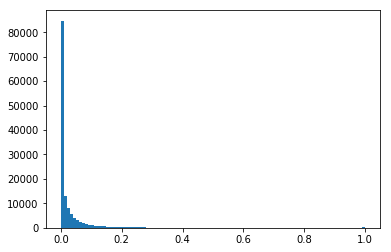

In [25]:
x_diff_small = x_diff_1d[[x < 1 for x in x_diff_1d]]
x_diff_small = pd.Series(x_diff_small)
plt.hist(x_diff_small, bins=100)

In [26]:
norm = x_diff.sum(axis=1)
norm

array([  8.99957  ,  19.557037 ,  18.306032 ,  14.395269 ,  14.264887 ,
        19.092701 ,  20.104155 ,   8.2963295,  14.308449 ,  15.594791 ,
         8.769597 ,  22.972172 ,   9.849191 ,  11.904107 , 228.29808  ,
        16.669113 ,  14.562326 ,   6.8042135,  22.771845 ,  28.63597  ,
        34.051662 ,   9.690867 ,  11.276712 ,  14.289453 ,  10.568748 ,
        34.337112 ,  11.667721 ,  10.498971 ,  14.0462055,  37.45764  ,
        18.594849 ,   7.715104 ,  47.63437  ,  24.743515 ,  21.607872 ,
        13.3252735,  35.060753 ,  14.661083 ,   6.3569937,  21.177023 ,
        13.755775 ,  31.669556 ,  32.43329  ,   7.991875 ,   8.437784 ,
        15.394779 ,  11.688414 ,  21.21623  ,  13.408206 ,   7.7709785,
        11.013085 ,  22.953167 ,   6.101374 ,  21.496525 ,  21.39008  ,
        10.393875 ,   9.501221 ,  16.172249 ,  14.886509 ,  11.648602 ,
       106.53521  ,   8.5138855,  25.52901  ,  49.022827 ,  29.25617  ,
       186.35913  ,   7.1421714,  13.738251 ,  18.491636 ,  15.3

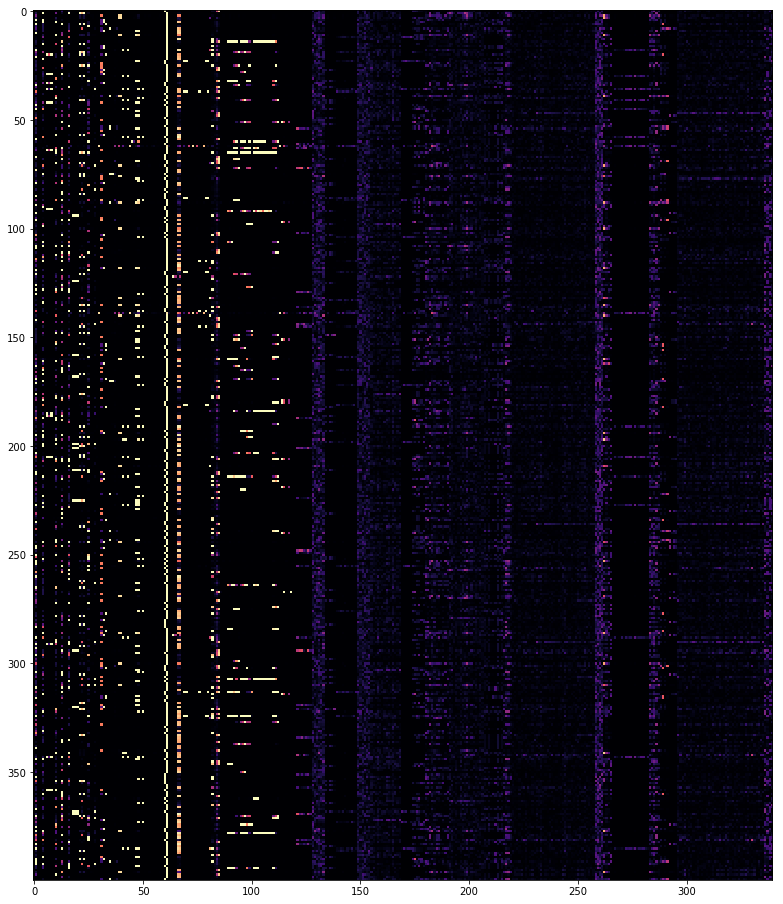

In [79]:
plt.figure(figsize=(16,16))
plt.imshow(np.clip(x_diff, 0, 1), cmap='magma')

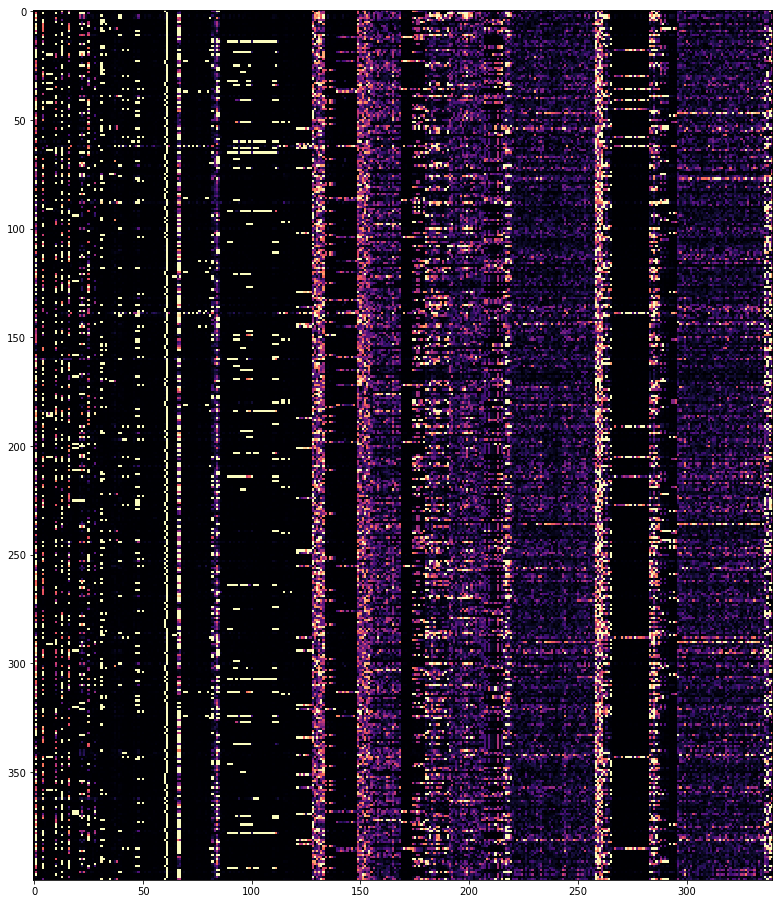

In [78]:
x_diff_small_1 = np.clip(x_diff, 0, 0.2)
x_diff_small_1 = (x_diff_small_1 - x_diff_small_1.min())/x_diff_small_1.max() 
plt.figure(figsize=(16,16))
plt.imshow(np.clip(x_diff_small_1, 0, 1), cmap='magma')

Text(0.5, 0.98, 'Difference Heat Map')

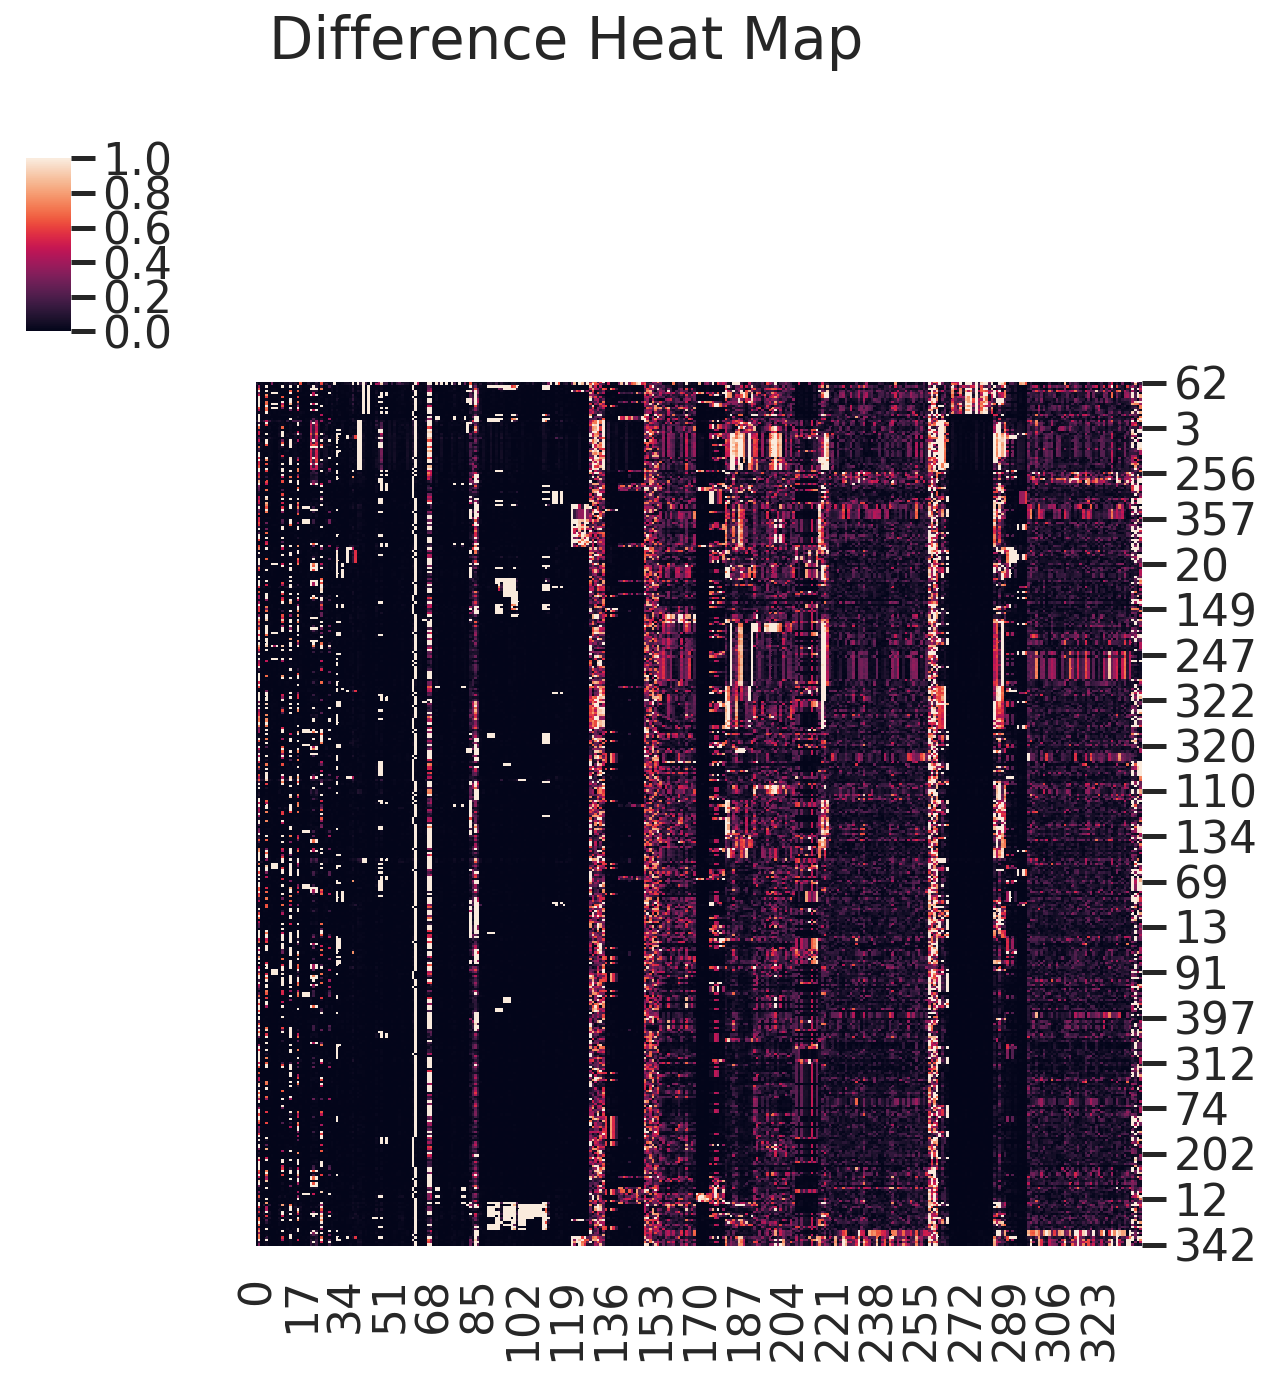

In [207]:
cg = sns.clustermap(np.clip(x_diff_small_1, 0, 1), col_cluster=False)
cg.ax_row_dendrogram.set_visible(False)
cg.fig.suptitle("Difference Heat Map")

In [29]:
x_diff_log = np.log(np.log(x_diff-x_diff.min()+1)+1)

In [30]:
x_diff_log.min(), x_diff_log.max(), x_diff_log.mean()

(0.0, 1.4767139, 0.031215778)

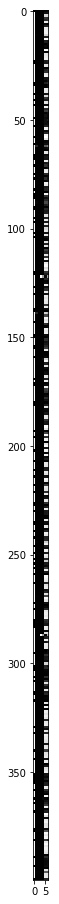

In [55]:
x_diff_log = (x_diff_log - x_diff_log.min())/x_diff_log.max() 
plt.figure(figsize=(16,16))
plt.imshow(np.clip(x_diff_log, 0, 1)[:, 61:68], cmap='gray')

In [125]:
print(len(index_cardinality_map))

22


In [137]:
original_dim = X_test.shape[1]
num_categorical_features = len(index_cardinality_map)
total_embedding_dimensions = sum(
    [int(np.ceil(cardinality**(1/3))) \
    for index, cardinality in index_cardinality_map.items()])
final_dim = original_dim - num_categorical_features + total_embedding_dimensions
final_dim

340

In [129]:

total_embedding_dimensions

122

In [138]:
temp_dict = dict() 
for index, cardinality in index_cardinality_map.items(): 
    val = int(np.ceil(cardinality**(1/3)))
    temp_dict[index] = val

keys = np.sort(list(temp_dict.keys()))
# print(keys)
sorted_array2 = []
total = 0 
for key in keys: 
    start = key + total 
    end = key + total + temp_dict[key]
    total += temp_dict[key]
    sorted_array2.append([key, start, end])
    
print(sorted_array2)

[[30, 30, 34], [40, 44, 49], [41, 50, 59], [42, 60, 74], [59, 91, 97], [73, 111, 118], [80, 125, 130], [81, 131, 141], [89, 149, 155], [91, 157, 161], [92, 162, 178], [93, 179, 186], [94, 187, 227], [95, 228, 232], [96, 233, 238], [101, 243, 260], [105, 264, 268], [130, 293, 297], [137, 304, 310], [138, 311, 315], [139, 316, 354], [140, 355, 359]]


In [155]:
temp_columns = list(test_data.columns)
for index, value in enumerate(temp_columns): 
    if index in temp_dict.keys(): 
        root_cardinality = temp_dict[index]
        temp_value_array = [] 
        for i in range(root_cardinality): 
            temp_value_array.append(str(value)+"_emb_"+str(i))
        temp_columns[index] = temp_value_array
    else: 
        temp_columns[index] = [value]

flat = [item for sublist in temp_columns for item in sublist]
flat = flat[0: -1]

In [162]:
heat_dataframe = pd.DataFrame(x_diff, columns=flat)
feature_importances = heat_dataframe.mean(axis=0).sort_values(ascending=False)
print(feature_importances.head(20))
print(feature_importances.tail(20))

category_id_emb_4     0.746949
am_1024847_bpr        0.470614
am_1062915_bpr        0.413367
category_id_emb_9     0.384890
category_id_emb_10    0.381316
conn_speed_5          0.380466
am_1024849_bpr        0.369848
day_of_week_2         0.365524
am_1057601_bpr        0.344745
am_1120848_bpr        0.336855
am_484934_pixel       0.269495
am_484934_bpf         0.268751
day_part_1            0.256678
category_id_emb_3     0.254424
creative_id_emb_4     0.245827
am_796704_bpr         0.215219
deal_id_emb_6         0.214696
creative_id_emb_2     0.211083
deal_id_emb_1         0.206159
deal_id_emb_4         0.200591
dtype: float32
am_1062915_pixel             0.001414
browser_version_emb_8        0.001394
device_manufacturer_emb_0    0.001351
browser_version_emb_5        0.001256
creative_id_emb_0            0.001215
category_id_emb_1            0.001209
mm_1213054_pixel             0.001116
device_manufacturer_emb_1    0.001019
category_id_emb_2            0.000968
browser_version_emb_4  

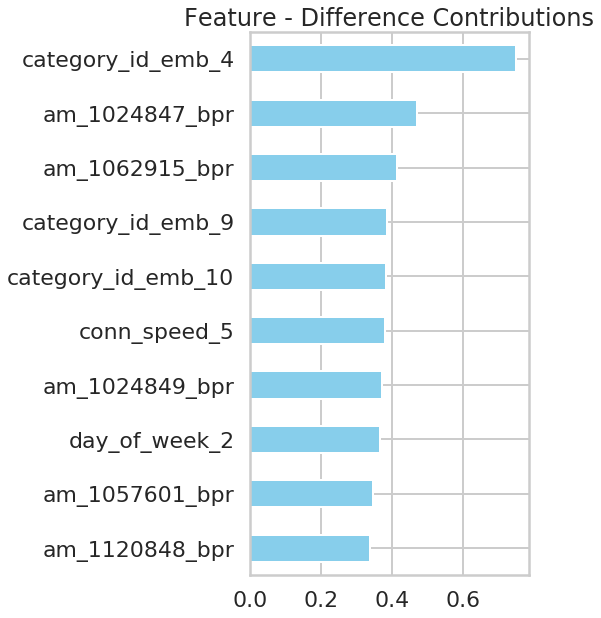

In [205]:
bar_data = feature_importances.head(10).sort_values(ascending=True)
ax1 = plt.axes()
bar_data.plot('barh', title = "Feature - Difference Contributions", figsize=(5, 10), alpha=1, ax=ax1, color='skyblue')

In [185]:
feature_importances.sort_values(ascending=True)

category_id_emb_11           0.000401
conn_speed_0                 0.000759
channel_type_1               0.000764
creative_id_emb_1            0.000764
browser_version_emb_1        0.000789
browser_id_0                 0.000824
channel_type_3               0.000850
browser_version_emb_3        0.000883
browser_version_emb_6        0.000889
category_id_emb_0            0.000927
browser_version_emb_4        0.000957
category_id_emb_2            0.000968
device_manufacturer_emb_1    0.001019
mm_1213054_pixel             0.001116
category_id_emb_1            0.001209
creative_id_emb_0            0.001215
browser_version_emb_5        0.001256
device_manufacturer_emb_0    0.001351
browser_version_emb_8        0.001394
am_1062915_pixel             0.001414
browser_version_emb_7        0.001420
am_1024849_bpf               0.001459
am_1062915_bpf               0.001502
am_1024849_pixel             0.001514
am_1024847_pixel             0.001528
category_id_emb_5            0.001529
am_1057601_p

((284492, 143), (284492, 144))